## TD;DR

After practicing with elastic material model, we'll continue to nonlinear material modelling: viscoplasticity. In this post we'll explore Norton and Birgin viscoplastic potential equations, von Mises yield function and automatic derivation using ForwardDiff. Most of the theory can be found from [here](http://mms2.ensmp.fr/msi_paris/plasticity/transparents/Expo2.pdf) and [here](http://mms2.ensmp.fr/msi_paris/archives-transparents/JLC-Plasticity.pdf).

**Note! Equations are written in tensor notation, but the implementated code is in matrix notation!**

## Recap to linear material modelling

Here's a small recap example from elastic material modelling with matrix notation. Do note that we're using now cyclic loading.

\begin{equation}
\sigma = C : \epsilon
\end{equation}

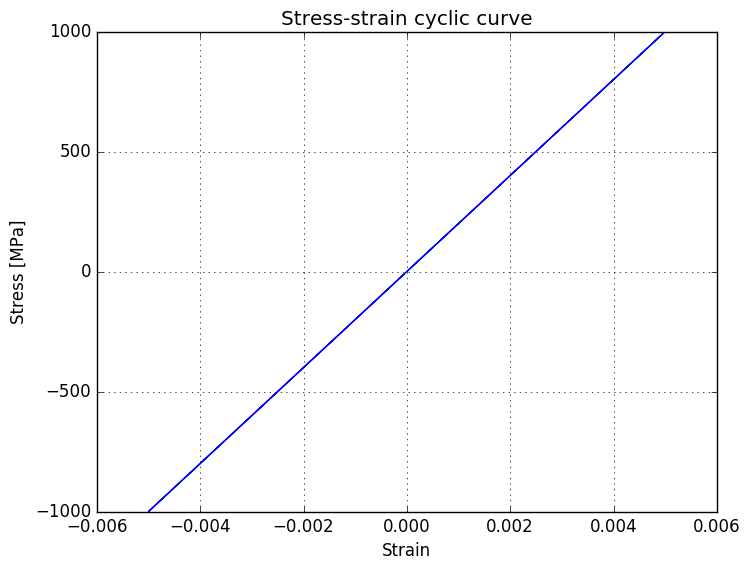

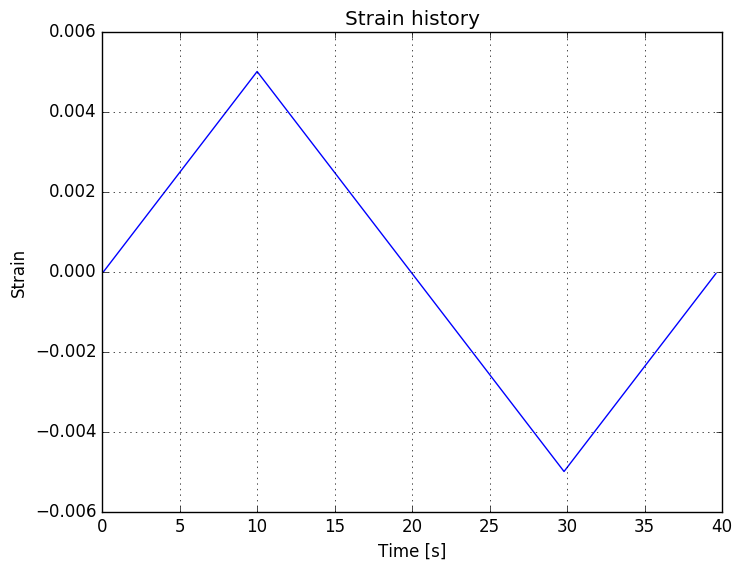

PyObject <matplotlib.text.Text object at 0x7f38d9d57950>

In [2]:
using PyPlot
using ForwardDiff

num = 100                  # Number of steps
E = 200000.0             # Young's modulus [GPa]
ν = 0.3                  # Poisson's ratio

L = 1000.0               # Initial length [mm]
ΔL = linspace(0, 5, num)   # Change of length [mm]

ϵ_ = collect(ΔL / L)
ϵ_total = vec([ϵ_; reverse(ϵ_[2:end-1]); -ϵ_; reverse(-ϵ_[2:end-1])])

Δt = 0.1
accumulator = 0.0
I = eye(3)
total_num = length(ϵ_total)
time_ = zeros(total_num)
σ = zeros(total_num, 6)

C = E / ((1 + ν)*(1 - 2*ν)) * [
    1-ν   ν   ν         0         0         0
      ν 1-ν   ν         0         0         0
      ν   ν 1-ν         0         0         0
      0   0   0 (1-2*ν)/2         0         0
      0   0   0         0 (1-2*ν)/2         0
      0   0   0         0         0 (1-2*ν)/2]

for i=1:(total_num)
    ϵ = zeros(6)
    ϵ[1] = ϵ_total[i]
    ϵ[2] = -ϵ_total[i] * ν
    ϵ[3] = -ϵ_total[i] * ν

    # The most general form of Hooke's law for isotropic materials
    σ[i, :] = C * ϵ
    
    accumulator += Δt
    time_[i] = accumulator
end

σ_11 = vec(σ[:, 1])

fig = figure()
grid()
plot(ϵ_total, σ_11)
ylabel("Stress [MPa]")
xlabel("Strain")
title("Stress-strain cyclic curve")
fig = figure()
grid()
title("Strain history")
plot(time_, ϵ_total)
xlabel("Time [s]")
ylabel("Strain")

## Nonlinear material

Stress is always related only to the elastic part of the the strain. The theory of plasticity is used to define the non-linear region of the material behaviour. Moving from linear to nonlinear modelling, we'll have to introduce a new variable: plastic strain $\epsilon^p$. Here's a definition for plasticity from [wiki](https://en.wikipedia.org/wiki/Plasticity_(physics)): 


> In physics and materials science, plasticity describes the deformation of a (solid) material undergoing non-reversible changes of shape in response to applied forces. For example, a solid piece of metal being bent or pounded into a new > shape displays plasticity as permanent changes occur within the material itself. In engineering, the transition from > elastic behavior to plastic behavior is called yield.




### Decomposition of strain
Theory presented here can be found from [here](http://eu.wiley.com/WileyCDA/WileyTitle/productCd-1118632702.html). Strain increment $de$ is decomposed into the elastic part de e and the plastic part de p using kinematics. Additive decomposition is used for small strains and multiplicative decomposition for large strains. In elasticplastic materials the strain increment is decomposed into an elastic and a plastic
part: 


\begin{equation}
d\epsilon = d\epsilon^e + d\epsilon^{vp}
\end{equation}

Dividing both sides with the differential time increment $dt$ produces the rate form:

\begin{equation}
\dot\epsilon = \dot\epsilon^e + \dot\epsilon^{vp}
\end{equation}

Diving previous equation with time increment and substituting elastic strain rate produces relation for linear region:

\begin{equation}
\dot\sigma = C : \dot\epsilon^e = C : (\dot\epsilon - \dot\epsilon^{vp})
\end{equation}

In the non-linear regime, the stress-strain relation is defined as:

\begin{equation}
\dot\sigma = C : \dot\epsilon^e = C^{tan} : \dot\epsilon
\end{equation}

Stress can now be expressed as:
\begin{equation}
\sigma = \int_0^t \dot\sigma dt'
\end{equation}

but usually, stress is more conveniently written as:

\begin{equation}
\sigma_{n+1} = \sigma_n + C : (\dot\epsilon - \dot\epsilon^{vp})
\end{equation}


### Yield function



Yield function defines the transition between elastic and plastic zones. One of the most common yield functions is [von Mises yield function](https://en.wikipedia.org/wiki/Von_Mises_yield_criterion), which is defined as: 

\begin{equation}
f(\sigma) = \sigma_{eq}(\sigma) - \sigma_y
\end{equation}

in which $\sigma_y$ is yield stress, which defines the limit, when plastic strain starts and $\sigma_{eq}$ is equivalent stress, which is expressed as:

\begin{equation}
\sigma_{eq}(\sigma) = \sqrt{3J_2(\sigma)}
\end{equation}

in which $J_2$ is second deviatoric stress invariant:

\begin{equation}
J_2(\sigma) = \frac{1}{2}s:s
\end{equation}

and $s$ is deviatoric stress, which is defined as:

\begin{equation}
s = \sigma - \frac{1}{3}\rm{tr}(\sigma)I
\end{equation}

in which tr is a trace operator and $\textbf{I}$ is second order identity tensor. What the yield function basically tells us: if the return value of given stress tensor is negative, we are in the elastic region and if the returned value is positive, we have exceeded the yield limit and ventured into plastic region. In order to take this into account in the implementation, we'll make a simple comparison operation with:

\begin{equation}
f(\sigma) > 0
\end{equation}

which will define, if we apply viscoplastic strain or not to our stress.

In [3]:
""" Deviatoric stress tensor
"""
function deviatoric_stress(σ)
    σ_tensor = [σ[1] σ[4] σ[6];
                σ[4] σ[2] σ[5];
                σ[6] σ[5] σ[3]]
    σ_dev = σ_tensor - 1/3 * trace(σ_tensor) * eye(3)
    return [σ_dev[1, 1], σ_dev[2, 2], σ_dev[3, 3], σ_dev[1, 2], σ_dev[2, 3], σ_dev[1, 3]] 
end

""" Second deviatoric stress invariant
"""
function J_2_stress(σ)
    s = deviatoric_stress(σ)
    s_vec = vec([s; s[4]; s[5]; s[6]])  # Adding missing shear elements for double dot product
    return 1/2 * dot(s_vec, s_vec)      # equivalent to sqrt(1/2 * s : s), in tensor notation 
end

""" Equivalent stress
"""
function equivalent_stress(σ)
    J_2 = J_2_stress(σ)
    return sqrt(3 * J_2)
end

""" Von mises yield function
"""
function von_mises_yield(σ, σ_y)
    return equivalent_stress(σ) - σ_y
end

von_mises_yield (generic function with 1 method)

In [4]:
using IJulia.display

HTML("""
<div>
<img src="von_mises_2d.png" alt="Mountain View" style="width:466px;height:350px;" align="left">
<video width="440" height="440" controls align="rigth">
  <source src="./vonmises_yield_surface.mp4" type="video/mp4">
</video>
</div>
""")

HTML{ASCIIString}("<div>\n<img src=\"von_mises_2d.png\" alt=\"Mountain View\" style=\"width:466px;height:350px;\" align=\"left\">\n<video width=\"440\" height=\"440\" controls align=\"rigth\">\n  <source src=\"./vonmises_yield_surface.mp4\" type=\"video/mp4\">\n</video>\n</div>\n")

Here are presented Von mises yield surfaces both in 2D and 3D. Used yield stress is 200 MPa. As you can see, von Mises yield surface is an oval in 2D plane. Inside the circle represents the elastic region and outside the circle the plastic region. Do note, that x- and y-axis are eigenstresses and not $\sigma_{x}$ and $\sigma_{y}$. 

3D presentation reveals the whole truth and we can see that the oval shape, which we saw in 2D plane, is marely a cross-section of the cylinder, which is the von Mises yield surface. The axis of the cylinder resides at hte hydrostatic pressure axis.



### Viscoplastic potential

Next we'll need to define the viscoplastic strain rate $\dot\epsilon^{vp}$:

\begin{equation}
\dot\epsilon^{vp} = \frac{\partial\Phi}{\partial\sigma}
\end{equation}
in which $\Phi$ is a plastic potential, which is a function of the stress and the material parameters. In the post, we'll look at both Norton rule and Bingham model. But first, the Norton rule:

\begin{equation}
\Phi = \frac{K}{n + 1} \left(\frac{J}{K}\right)^{n+1}, \hspace{1cm} J = f(\sigma)
\end{equation}

in which $K$ and $n$ are material parameters and $f$ is an yield function. When we use von Mises yield function, we can derivate this function with $\sigma$:

\begin{equation}
\frac{\partial\Phi}{\partial\sigma} = \left(\frac{J}{K}\right)^{n}\frac{3}{2}\frac{s}{\sigma_{eq}}
\end{equation}


In [5]:
""" Norton rule
"""
function norton_plastic_potential(σ, K, n, f)
    f_ = f(σ)
    return K/(n+1) * (f_ / K) ^ (n + 1)
end

""" Analytically derivated norton rule
"""
function analytical_dΦdσ(σ, K, n, f)
    f_ = f(σ)
    σ_v = equivalent_stress(σ)
    σ_dev_vec = deviatoric_stress(σ)
    return (f_ / K) ^ n * 3 / 2 * σ_dev_vec / σ_v
end

analytical_dΦdσ (generic function with 1 method)

### Summary of needed functions

Here's a summarize of the main functions, which we need:

\begin{equation}
\sigma_{n+1} = \sigma_n + C : (\dot\epsilon - \dot\epsilon^{vp}) \hspace{1.5cm}\dot\epsilon^{vp} = \left(\frac{J}{K}\right)^{n}\frac{3}{2}\frac{s}{\sigma_{eq}}\hspace{1.5cm} J = f(\sigma) = \sigma_{eq}(\sigma) - \sigma_y
\end{equation}

Now, we can proceed to the simulation:

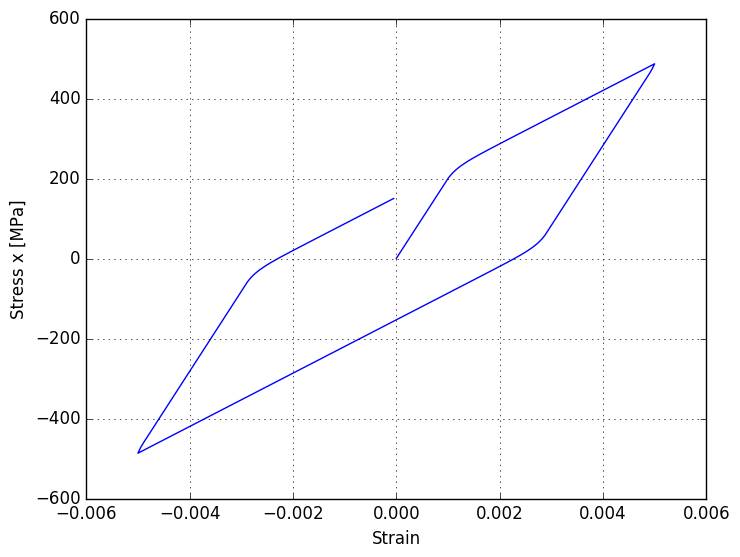

PyObject <matplotlib.text.Text object at 0x7ff74adb2610>

In [5]:
# Create an empty history vectors
σ_hist = zeros(total_num, 6)
ϵ_hist = zeros(total_num, 6)

# Initialize arrays
ϵ_last = zeros(6)
σ = zeros(6)
ϵ = zeros(6)

# We'll define our yield limit to be 200 MPa
σ_y = 200.0

# Define Δt, K and n
Δt = 0.1 
n = 0.92
K = 180.0e3

# Let's make a currier function to make it pretty!
f = x->von_mises_yield(x, 200.)

# Ok, going through time steps
for i=2:total_num
    ϵ = zeros(6)
    ϵ[1] = ϵ_total[i]
    ϵ[2] = -ϵ_total[i] * ν
    ϵ[3] = -ϵ_total[i] * ν
    
    # Trial stress
    dϵdt = (ϵ - ϵ_last) / Δt
    dσdt = C * dϵdt
    σ_tria = σ + dσdt * Δt
    
    # Checking if yielded
    yield_ = f(σ_tria)
    if yield_ > 0
        
        # If yielded, we'll add the viscoplastic strain to stress
        dϵ_vp = analytical_dΦdσ(σ_tria, K, n, f)
        σ += C * (dϵdt - dϵ_vp) * Δt
    else
        σ[:] = σ_tria
    end
    
    # Collect data
    σ_hist[i, :, :] = σ
    ϵ_last[:] = ϵ
    ϵ_hist[i, :] = ϵ
end

# Plot
plot(ϵ_hist[:, 1], σ_hist[:, 1])
grid()
xlabel("Strain")
ylabel("Stress x [MPa]")

As you can see, plot has now changed. At 200 MPa our stress exceeds the yield limit and viscoplastic strain is added. After reaching 0.004 strain level, we'll start to go back to the zero and return to the elastic strain region. At ~20 MPa we again exceed the yield limit again and start adding viscoplastic strain. I also wanted to show the power of automatic derivation using ForwardDiff in the same calculation.

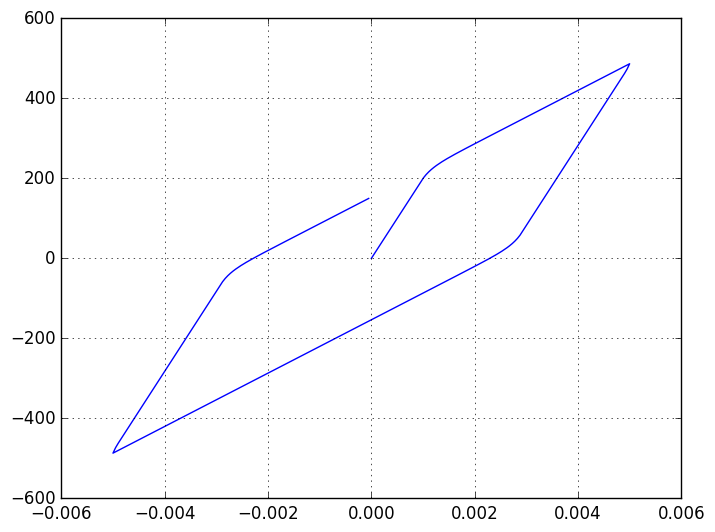

In [6]:
σ_hist = zeros(total_num, 6)
ϵ_hist = zeros(total_num, 6)

ϵ_last = zeros(6)
ϵ = zeros(6)
σ = zeros(6)

σ_y = 200.0
Δt = 0.1
n = 0.92
K = 180.0e3

f = x->von_mises_yield(x, σ_y)

for i=2:total_num
    ϵ = zeros(6)
    ϵ[1] = ϵ_total[i]
    ϵ[2] = -ϵ_total[i] * ν
    ϵ[3] = -ϵ_total[i] * ν
    
    dϵdt = (ϵ - ϵ_last) / Δt
    dσdt = C * dϵdt
    σ_tria = σ + dσdt * Δt
    yield_ = f(σ_tria)
    if yield_ > 0
        wrap = x-> norton_plastic_potential(x, K, n, f)
        
        # This part is different. As you can see, we'll take a numerical derivate
        # Way more convenient compared to hand derivated potential function
        dϵ_vp = ForwardDiff.gradient(wrap, σ_tria)
        σ += C * (dϵdt - dϵ_vp) * Δt
    else
        σ[:] = σ_tria
    end
    σ_hist[i, :, :] = σ
    ϵ_last[:] = ϵ
    ϵ_hist[i, :] = ϵ
end
plot(ϵ_hist[:, 1], σ_hist[:, 1])
grid()

Using the ForwardDiff now enables me to derivate quite complex looking function and also saves time from debugging hand derivated function. Lastly, we'll try another viscoplastic potential (Bingham model) for our plastic strain rate, which is defined as:

\begin{equation}
\Phi = \frac{1}{2} \left(\frac{J}{\eta}\right)^2, \hspace{1cm} J=f(\sigma)
\end{equation}

In [12]:
function bingham_plastic_potential(σ, η, f)
    return 0.5 * (f(σ) / η) ^2
end

bingham_plastic_potential (generic function with 1 method)

Now that we've discovered the power of ForwardDiff, we'll use automatic derivation also in this simlation.

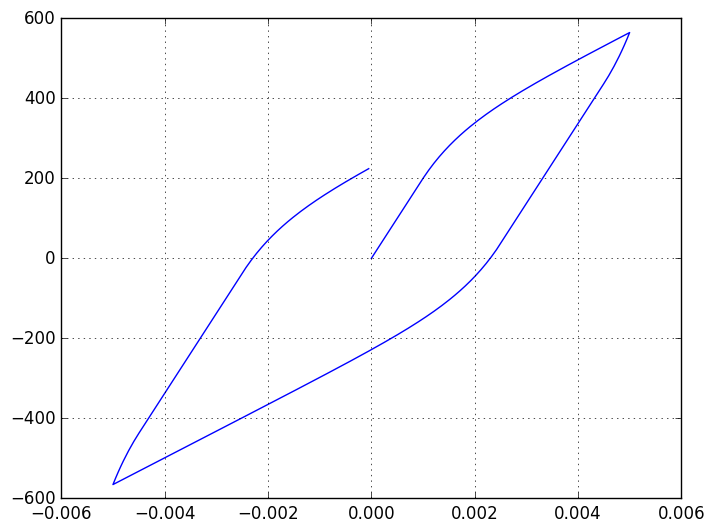

In [11]:
ϵ_last = zeros(6)
ϵ_hist = zeros(total_num, 6)
σ_hist = zeros(total_num, 6)
σ = zeros(6)
σ_y = 200.0

Δt = 0.01
ϵ = zeros(6)

# Parameter for Bingham model
η=190.

f = x->von_mises_yield(x, σ_y)

for i=2:total_num
    ϵ = zeros(6)
    ϵ[1] = ϵ_total[i]
    ϵ[2] = -ϵ_total[i] * ν
    ϵ[3] = -ϵ_total[i] * ν
    
    dϵdt = (ϵ - ϵ_last) / Δt
    dσdt = C * dϵdt
    σ_tria = σ + dσdt * Δt
    yield_ = f(σ_tria)
    if yield_ > 0        
        wrap = x->bingham_plastic_potential(x, η, f)
        
        # Again, I'm a bit lazy and just use ForwardDiff
        dϵ_vp = ForwardDiff.gradient(wrap, σ_tria)
        σ += C * (dϵdt - dϵ_vp) * Δt
    else
        σ[:] = σ_tria
    end
    σ_hist[i, :, :] = σ
    ϵ_last[:] = ϵ
    ϵ_hist[i, :] = ϵ
end
plot(ϵ_hist[:, 1], σ_hist[:, 1])
grid()

## The End

In this post we have seen how to implement non-linear viscoplastic material model. Varying yield function or viscoplastic potential we can create different material responses. 